### 177 - Weighted Regression

We can calculate the Year from the date column using either a list comprehension or the data frame's "apply" method.

In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage


import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
house = pd.read_csv('house_sales.csv', sep='\t')
house.head()

,DocumentDate,SalePrice,PropertyID,PropertyType,ym,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,...,Bathrooms,Bedrooms,BldgGrade,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction
1,2014-09-16,280000,1000102,Multiplex,2014-09-01,405100,0.930836,300805.0,2,9373,...,3.00,6,7,1991,0,0,70000,229000,98002,False
2,2006-06-16,1000000,1200013,Single Family,2006-06-01,404400,0.929228,1076162.0,1,20156,...,3.75,4,10,2005,0,0,203000,590000,98166,True
3,2007-01-29,745000,1200019,Single Family,2007-01-01,425600,0.977941,761805.0,1,26036,...,1.75,4,8,1947,0,0,183000,275000,98166,False
4,2008-02-25,425000,2800016,Single Family,2008-02-01,418400,0.961397,442065.0,1,8618,...,3.75,5,7,1966,0,0,104000,229000,98168,False
5,2013-03-29,240000,2800024,Single Family,2013-03-01,351600,0.807904,297065.0,1,8620,...,1.75,4,7,1948,0,0,104000,205000,98168,False


In [32]:
# Preparing data for our weighted regression by creating weights based on how recent each house sale is
    # We're starting with "house.DocumentDate', which contains dates in a string format like "2015-03-25". 
    # We want to extract just the year from each date. 

    # This first line uses a list comprehension to:
    #    - Take each date string from DocumentDate
    #    - Split it at the hyphens using split('-'), creating a list like ["2015", "03", "25"]
    #    - Take the first element [0] which is the year
    #    - Convert that string to an integer using int()
    #    - Create a NEW column 'Year' with these extracted years
house['Year'] = [int(date.split('-')[0]) for date in house.DocumentDate]


    # The second line does exactly the same thing but uses pandas apply() method:
    # Here, we're using "apply()" to run a small function (a lambda function) on each date. 
    # The lambda function does the same splitting and conversion as before, just in a more "pandas-style" way.
house['Year'] = house.DocumentDate.apply(lambda d: int(d.split('-')[0]))


    # We create the weights
    # This creates a new column where each house's weight is based on how many years after 2005 it was sold. 
house['Weight'] = house.Year - 2005

In [18]:
# This code compares a regular linear regression with a weighted linear regression to see 
# how giving more importance to recent house sales affects our model coefficients.

    # We first establish our basic modeling setup,
    # predictors and outcome variables:

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'


    # We create and fit two different models. The first is our regular linear regression:

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])


    # The second model is our weighted regression
    # The key difference is the "sample_weight=house.Weight" parameter 
    # These are rhe weights we created above, Houses sold more recently (with higher weights) 
    # will have more influence on determining the coefficients.
house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome], sample_weight=house.Weight)

    # This creates a nicely formatted comparison of the coefficients from both models:
    # This combines two DataFrames, 
    # The first DataFrame contains the coefficients for our predictor variables 
    # The second DataFrame contains the intercepts (we handle these separately because they're stored differently in scikit-learn)
    # The result is a table that lets us see how each coefficient changes when we weight by time

    # INTERPRETATION:
    # If a coefficient is larger in house_wt, it means that feature has become more important 
    # in determining house prices in recent years. If it's smaller, that feature has become less important over time.

pd.concat([
    pd.DataFrame({
        'predictor': predictors,
        'house_lm': house_lm.coef_,
        'house_wt': house_wt.coef_,    
    }),
    pd.DataFrame({
        'predictor': ['intercept'],
        'house_lm': house_lm.intercept_,
        'house_wt': house_wt.intercept_,    
    })
])


,predictor,house_lm,house_wt
0,SqFtTotLiving,228.830604,245.024089
1,SqFtLot,-0.060467,-0.292415
2,Bathrooms,-19442.840398,-26085.970109
3,Bedrooms,-47769.955185,-53608.876436
4,BldgGrade,106106.963079,115242.434726
0,intercept,-521871.368188,-584189.329446


   abs_residual_lm  abs_residual_wt  Year
1    123750.814194    107108.553965  2014
2     59145.413089     96191.882094  2006
3    190108.725716    187004.492880  2007
4    198788.774412    196132.996857  2008
5     91774.996129     84277.577512  2013

number of entries:  22687 



,Year,mean abs_residual_lm,mean abs_residual_wt
0,2006,140540.303585,146557.454636
1,2007,147747.577959,152848.523235
2,2008,142086.905943,146360.411668
3,2009,147016.720883,151182.924825
4,2010,163267.674885,166364.476152
5,2011,169937.385744,172950.876028
6,2012,169506.670053,171874.424266
7,2013,203659.777510,206242.199403
8,2014,184452.840665,186668.573750
9,2015,172323.435147,169842.742053


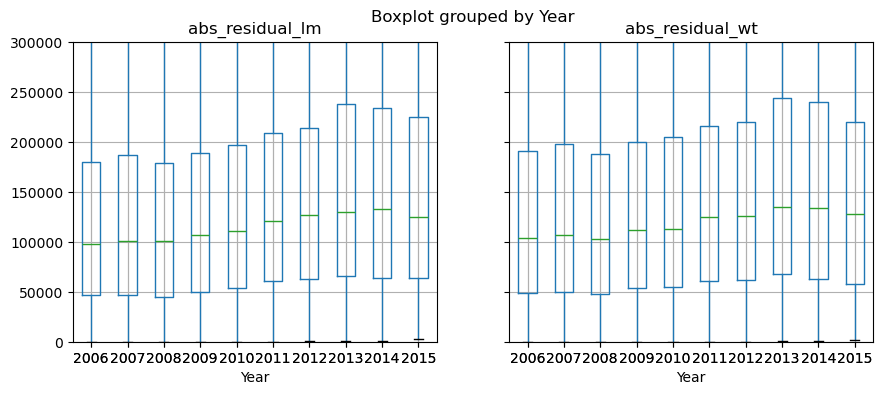

In [60]:
# This compares how accurate our regular and weighted regression models are across different years:

    # First, we create a DataFrame to store the prediction errors (residuals) from both models (residuals = pd.DataFrame() )

    # For 'abs_residual_lm', we:
    #    - Use our regular model (house_lm) to predict prices
    #    - Subtract actual prices (house[outcome])
    #    - Take the absolute value (np.abs) because we care about size of error, not direction

    # For 'abs_residual_wt', we do the same thing but with our weighted model (house_wt)

    # We also include the Year column to group our errors by when the houses were sold
    

residuals = pd.DataFrame({

    'abs_residual_lm': np.abs(house_lm.predict(house[predictors]) - house[outcome]),
    'abs_residual_wt': np.abs(house_wt.predict(house[predictors]) - house[outcome]),
    'Year': house['Year'],
})

    # This prints an extract of those absolute residuals:
    # This is all the many many entries
print(residuals.head())
print("\nnumber of entries: ", residuals.shape[0], "\n")

    # Visualization:
axes = residuals.boxplot(['abs_residual_lm', 'abs_residual_wt'], by='Year', figsize=(10, 4))
axes[0].set_ylim(0, 300000)


    # This creates a summary of these errors by year:

    #    - Group the residuals by year using residuals.groupby('Year')
    #    - For each year and its group of houses:
    #         - Calculate the average prediction error for the regular model
    #         - Calculate the average prediction error for the weighted model
    #    - Put these yearly averages into a new DataFrame with clear column names


    # This is not a list comprehension, it's a generator expression being passed to "pd.DataFrame()"

    # First, let's look at what "residuals.groupby('Year')" gives us. 
    # When we group by year, we create separate groups of houses sold in each year (like sorting papers into different folders)

    # MORE BELOW on the following block.
    # This is not a list comprehension, but a generator
    # Think of a list comprehension like baking all your cookies at once, 
    # while a generator expression is like having a machine that makes cookies one at a time as needed. 
    # Both give you cookies, but they work differently behind the scenes

pd.DataFrame(([year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt'])] 
              
              for year, group in residuals.groupby('Year')),
             columns=['Year', 'mean abs_residual_lm', 'mean abs_residual_wt'])
# for year, group in residuals.groupby('Year'):
#     print(year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt']))



In [80]:
# MORE ON:
#pd.DataFrame(([year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt'])]               
#              for year, group in residuals.groupby('Year')),
#             columns=['Year', 'mean abs_residual_lm', 'mean abs_residual_wt'])



# This is what the code is doing, just written out step by step

    # When we create "year_groups = residuals.groupby('Year')", we create a special pandas object called a GroupBy object.
    # Think of it like a sorting system that has organized all our data into virtual "folders" by year, 
    # but hasn't actually done any calculations yet. 
    # It's just waiting for instructions about what to do with these groups.

    # This code is processing the residuals from two regression models 
    # (a regular model and a weighted model) and calculating the average absolute residual error for each year. 
    # It then creates a DataFrame summarizing this information.

    # Groups the residuals DataFrame by the Year column.
    # groupby('Year'): Groups the data based on the Year column, creating separate subsets (groups) for each unique year.
year_groups = residuals.groupby('Year')


    # Initializes an empty list to collect data that will later be used to create a DataFrame.
data_for_dataframe = []


    # Iterating Through Year Groups
    # year is something like 2015
    # group is all the houses sold in that year
    # Each group in the GroupBy object is a subset of the original DataFrame,
    # containing all the columns but only the rows corresponding to a specific year.

    # What Happens in the Loop?
    #     year: The key that identifies the group (the unique value from the Year column). For example, it might be 2015 or 2016.
    #     group: The subset of the DataFrame for that specific year. 
    #     This will contain all the columns of the residuals DataFrame, but only the rows for that particular year.

    # If your original DataFrame (residuals) contains columns like Year, abs_residual_lm, abs_residual_wt, and other features, 
    # then for each iteration:
    #    - year will be the specific year value (2015, 2016..)
    #    - group will be a subset of the original residuals DataFrame, containing all columns for just that specific year.

for year, group in year_groups:

    
    #Inside the loop, you can reference any column of the group DataFrame 
    # (which is just a subset of the original residuals DataFrame).

    # group['abs_residual_lm'] refers to the abs_residual_lm column for all rows in the current year group.
    
    # Calculate average error for regular model in this year
    avg_error_regular = np.mean(group['abs_residual_lm'])
    
    # Calculate average error for weighted model in this year
    avg_error_weighted = np.mean(group['abs_residual_wt'])
    
    # Create a row of data for this year
    row = [year, avg_error_regular, avg_error_weighted]
    data_for_dataframe.append(row)

# Create DataFrame from our collected data
result = pd.DataFrame(
    data=data_for_dataframe,
    columns=['Year', 'mean abs_residual_lm', 'mean abs_residual_wt']
)

In [84]:
# Let's see what's actually in these "groups" with some example code:

for year, group_data in year_groups:
    print(f"\nYear: {year}")
    print(f"Number of houses in this year: {len(group_data)}")
    print("First few rows of data for this year:")year_groups
    print(group_data.head(2))  # Show first 2 rows from this year's group


# Each group contains all the rows from our original DataFrame where the Year column matches that group's year. 
# What makes this powerful is that we can then perform operations on each group separately:



Year: 2006
Number of houses in this year: 8176
First few rows of data for this year:
   abs_residual_lm  abs_residual_wt  Year
2     59145.413089     96191.882094  2006
9      5230.968270     16260.412448  2006

Year: 2007
Number of houses in this year: 4928
First few rows of data for this year:
   abs_residual_lm  abs_residual_wt  Year
3    190108.725716    187004.492880  2007
8     71022.121503     64391.057257  2007

Year: 2008
Number of houses in this year: 2355
First few rows of data for this year:
    abs_residual_lm  abs_residual_wt  Year
4     198788.774412    196132.996857  2008
13    134928.009777    149176.667335  2008

Year: 2009
Number of houses in this year: 1878
First few rows of data for this year:
    abs_residual_lm  abs_residual_wt  Year
6       3250.434403      7198.919026  2009
29    178880.292278    202765.581565  2009

Year: 2010
Number of houses in this year: 1711
First few rows of data for this year:
    abs_residual_lm  abs_residual_wt  Year
12     86085.7962

In [88]:

# We can get summary statistics for each year
yearly_means = year_groups.mean()
print("\nMean values for each year:")
print(yearly_means)


Mean values for each year:
      abs_residual_lm  abs_residual_wt
Year                                  
2006    140540.303585    146557.454636
2007    147747.577959    152848.523235
2008    142086.905943    146360.411668
2009    147016.720883    151182.924825
2010    163267.674885    166364.476152
2011    169937.385744    172950.876028
2012    169506.670053    171874.424266
2013    203659.777510    206242.199403
2014    184452.840665    186668.573750
2015    172323.435147    169842.742053


In [90]:
# The GroupBy object is like a smart filing system that:
#    - Sorts our data into categories (in this case, years)
#    - Keeps track of which rows belong to which category
#    - Waits for us to tell it what calculations to perform on each group
#    - Maintains the relationship between our data and its categories

In [92]:
residuals

,abs_residual_lm,abs_residual_wt,Year
1,123750.814194,107108.553965,2014
2,59145.413089,96191.882094,2006
3,190108.725716,187004.492880,2007
4,198788.774412,196132.996857,2008
5,91774.996129,84277.577512,2013
...,...,...,...
27057,61921.802132,66735.636036,2011
27058,140828.931399,85020.026656,2007
27061,72322.919386,95090.694847,2012
27062,3875.703833,4960.153663,2006
